# Examine Results

In [1]:
from pathlib import Path

import pandas as pd

from convnwb.io import get_files, load_json

from spiketools.plts.data import plot_hist
from spiketools.plts.utils import make_axes

In [2]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [3]:
# Set which task to run
task = 'THF'

In [4]:
# Set the folder to load results from
base_path = Path('../results/units/')
data_path = base_path / task

In [5]:
# Get the list of files
res_files = get_files(data_path, select='json')

In [6]:
# Check the number of available files
n_files = len(res_files)

## Load Example File

In [7]:
# Load an example file
file = res_files[0]
data = load_json(file, folder=str(data_path))

In [8]:
# Check example file
data

{'session': 'THF_wv001_session_0',
 'uid': 10,
 'wvID': 11,
 'keep': True,
 'cluster': 1571,
 'channel': 'A16',
 'location': 'LAH',
 'n_spikes': 2291,
 'firing_rate': 1838.7560066057742,
 'fr_t_val': -0.335561371762666,
 'fr_p_val': 0.7384783239796033,
 'place_info': 1.6642444829739589,
 'place_p_val': 0.36,
 'place_z_score': 0.5161622973139365,
 'target_info': 3.773372526428895,
 'target_p_val': 0.39,
 'target_z_score': 0.3905937249743087,
 'hd_z_val': 4.319161772293733,
 'hd_p_val': 0.013246385441277002,
 'hd_surr_p': 0.13,
 'hd_surr_z': 1.0980174132116776}

## Collect Results

NOTES:
- 

In [9]:
# Collect all unit results together into a dataframe
all_results = pd.DataFrame()
for file in res_files:
    cur_results = load_json(file, folder=data_path)
    all_results = all_results.append(cur_results, ignore_index=True)

In [10]:
# Clean up some datatypes - cast integers
set_ints = ['uid', 'wvID', 'keep', 'cluster', 'n_spikes']
all_results[set_ints] = all_results[set_ints].astype('int')

In [11]:
# Check the columns
all_results.columns

Index(['session', 'uid', 'wvID', 'keep', 'cluster', 'channel', 'location',
       'n_spikes', 'firing_rate', 'fr_t_val', 'fr_p_val', 'place_info',
       'place_p_val', 'place_z_score', 'target_info', 'target_p_val',
       'target_z_score', 'hd_z_val', 'hd_p_val', 'hd_surr_p', 'hd_surr_z',
       'fr_p_val_all', 'fr_p_val_empt', 'fr_p_val_full', 'fr_t_val_all',
       'fr_t_val_empt', 'fr_t_val_full', 'sp_p_val_0', 'sp_p_val_1',
       'sp_p_val_2', 'sp_p_val_3', 'sp_z_score_0', 'sp_z_score_1',
       'sp_z_score_2', 'sp_z_score_3'],
      dtype='object')

In [12]:
# Check the head of the results
all_results.head()

,session,uid,wvID,keep,cluster,channel,location,n_spikes,firing_rate,fr_t_val,...,fr_t_val_empt,fr_t_val_full,sp_p_val_0,sp_p_val_1,sp_p_val_2,sp_p_val_3,sp_z_score_0,sp_z_score_1,sp_z_score_2,sp_z_score_3
0,THF_wv001_session_0,10,11,1,1571,A16,LAH,2291,1838.756007,-0.335561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,THF_wv001_session_0,11,12,1,2044,A17,LPH,1400,1110.418593,-0.204255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,THF_wv001_session_0,12,13,1,2130,A17,LPH,702,555.959172,-0.448272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,THF_wv001_session_0,13,14,1,2195,A17,LPH,635,502.897181,0.360277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,THF_wv001_session_0,14,15,1,2207,A17,LPH,1135,898.879457,-3.039444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Firing Rate Checks

In [13]:
# Add a marker for firing rate threshold in our task
all_results['fr_keep_th'] = (all_results['firing_rate'] < 0.5).values

### Binary labels

In [14]:
# Set significance level
ALPHA_LEVEL = 0.05

In [15]:
# Add columns 
all_results['is_place_cell'] = all_results['place_p_val'] < ALPHA_LEVEL
all_results['is_target_cell'] = all_results['target_p_val'] < ALPHA_LEVEL
all_results['is_face_fr_cell'] = all_results['fr_t_val'] < ALPHA_LEVEL
all_results['is_head_direction_cell'] = all_results['hd_p_val'] < ALPHA_LEVEL

### Check numbers

In [16]:
# Check the total number of cells
print('Total number of cells: {}'.format(n_files))

Total number of cells: 72


## Check Results

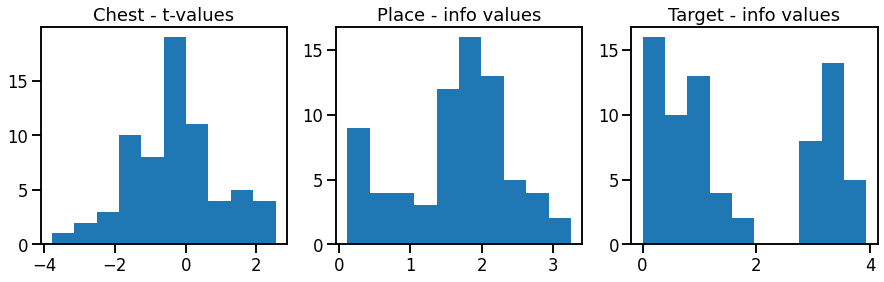

In [17]:
# Plot the distributions of measured values
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.fr_t_val.values, title='Chest - t-values', ax=axes[0])
plot_hist(all_results.place_info.values, title='Place - info values', ax=axes[1])
plot_hist(all_results.target_info.values, title='Target - info values', ax=axes[2])

## Save out results

In [18]:
# Save out of CSV
#all_results.to_csv(task + '_all_results.csv')